<a href="https://colab.research.google.com/github/vmazashvili/Neural-Networks/blob/main/MaskTune_Vano_Mazashvili_1993251.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masktune

Masktune is a single-epoch finetuning technique that prevents a model from learning only the "first" simplest mapping (potentially spurious correlations) from the input to the corresponding target variable. It forces the model to explore other train variables by concealing the first explored ones, causing the training to escape its myopic and greedy feature-seeking approach and encourage exploring, leveraging more input variables.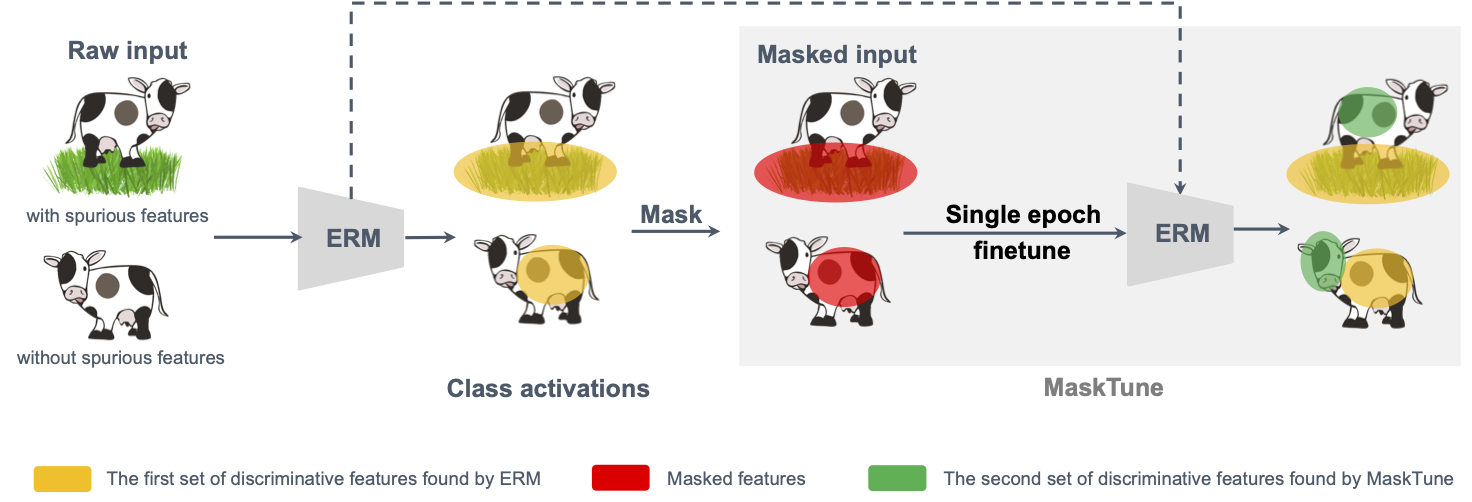

Project outline:

1.   **Train the model using** Empirical Risk Minimization (**ERM**)


2.  After the initial training with the empirical risk minimization, we can apply Masktune, which incorporates:

    - **Image masking** - identifying and masking the most influential, potentially spurious features
        1.  **Identify the spurious features** / class activations from saliency maps. In case of present spurious features, the method will likely identify the spurious feature, while for the input without any spurious features, the function will identify the most prominent features to mask, forcing the training to escape its myopic and greedy feature-seeking approach and encouraging and leveraging more input variables [1]

        2.  **Generate masks** to cover the most discriminatory features discovered in the saliency maps.

    - **Mask Application** -  masked data will force the model to explore less prominent and potentially more descriptive non-spurious features.

3.  The generated masks from the step 3 will be applied to the dataset
5.  We will **fine-tune** the pretrained ERM model on newly masked dataset only for one epoch.



### Dependencies

In [1]:
!pip install torch torchvision #timm
!pip install torchcam
!pip install pytorch-gradcam

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import resize
from torchcam.methods import XGradCAM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## MNIST DATASET

We will be implementing the method on MNIST dataset. The database setup is the following:
- [x] Distinguish between two MNIST digit groups (0-4 and 5-9)
- [x] 0-4 into class 0 and 5-9 into class 1.
- [x] Transform 99% of new class 0 and 1% of the new class 1 so that they acquire same spurious feature (square in top left corner)
- [x] Two test sets during testing: the original raw MNIST test set and a biased test set.
- [x] biasd test set - add spurious feature to only 5-9 group  

### **Step 1: Remap the dataset**

After downloading and normalizing the MNIST training and test datasets using torchvision, we:

Remap the 10 classes (0-9) to 2 (0, 1).

Digits 0-5 are labeled with class 0, digits 5-9 are labeled with class 1.

The remapped classes are saved into `remapped_train_data` and `remapped_test_data` lists.

Each element is `(PIL.Image.Image instance, class_label)`

In [3]:
import torch
from torchvision import datasets

def remap_classes(dataset):
    """
    Remap MNIST dataset classes to two new classes
    new_to_old_label_mapping={0: [0, 1, 2, 3, 4], 1: [5, 6, 7, 8, 9]},

    Input:
        MNIST dataset

    Output:
        List of remapped dataset. Each item is (PIL image, class)
    """
    remapped_data = []
    remapped_targets = []

    for data, target in dataset:
        if target < 5:  # Digits 0-4
            remapped_targets.append(0)
        else:  # Digits 5-9
            remapped_targets.append(1)

        remapped_data.append(data)

    return list(zip(remapped_data, remapped_targets))

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True)
mnist_test = datasets.MNIST(root='data', train=False, download=True)

# Remap the classes, the variables contain lists:
remapped_train_data = remap_classes(mnist_train)
remapped_test_data = remap_classes(mnist_test)

# Print class distributions
print("Original class distribution in train set:", mnist_train.targets.bincount())
print("Remapped class distribution in train set:", torch.tensor([target for _, target in remapped_train_data]).bincount())

print("Original class distribution in test set:", mnist_test.targets.bincount())
print("Remapped class distribution in test set:", torch.tensor([target for _, target in remapped_test_data]).bincount())


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18161129.71it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 492884.35it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4422655.01it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4625037.33it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Original class distribution in train set: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
Remapped class distribution in train set: tensor([30596, 29404])
Original class distribution in test set: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
Remapped class distribution in test set: tensor([5139, 4861])


Check the first element of the list

In [4]:
remapped_train_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 1)

### **Step 2: Add Spurious Features to the Dataset**

Apply spurious feature, a blue square in the top left corner of the image, to the 99% of samples of class 0, and 1% of class 1 in `remapped_train_data` list of tuples.

The results are saved in `train_data_spuriousus` list of tuples.

The images are transformed from grayscale to RGB, for the proper implementation of the blue spurious feature.


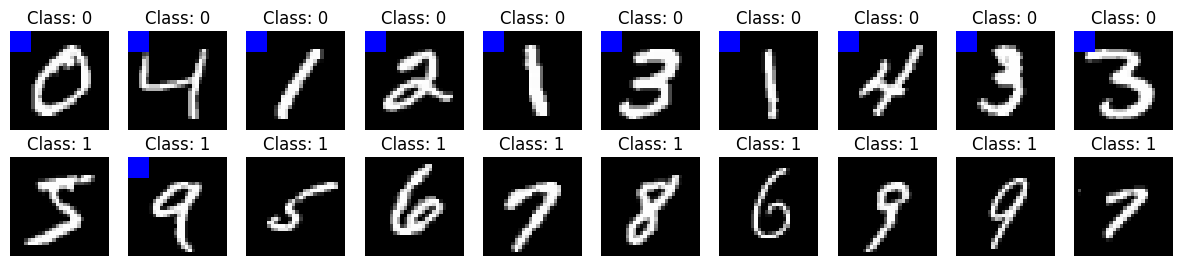

In [5]:
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def add_spurious_feature(image, label, percentage_class_0=0.99, percentage_class_1=0.01):
    """
    A function to add blue spurious features to PIL images based on class-specific percentages.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        percentage_class_0 (float, optional): Percentage of class 0 samples to apply the feature to. Defaults to 0.99.
        percentage_class_1 (float, optional): Percentage of class 1 samples to apply the feature to. Defaults to 0.01.

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature.
    """
    percentage = percentage_class_0 if label == 0 else percentage_class_1

    if random.random() < percentage:
        image_with_spurious = image.convert("RGB")  # Ensure the image is in RGB mode
        draw = ImageDraw.Draw(image_with_spurious)
        draw.rectangle([0, 0, 5, 5], fill=(0, 0, 255))  # Blue color
        del draw  # Release drawing context
        return image_with_spurious
    else:
        return image.convert("RGB")

# Apply add_spurious_feature to the entire remapped_train_data dataset
train_data_spurious = [(add_spurious_feature(image, label), label) for image, label in remapped_train_data]

# Display 10 samples from each class
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in train_data_spurious:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.show()


Copy `remapped_test_data` to `test_data_raw`, so that we can modify the original test dataset and save it in `test_data_spurious`. Both of them are lists of tuples of PIL images and class labels.

In this way, we are able to test the trained model on both, original and the biased test datasets.

The `test_data_spurious` has each sample of class 1 modified with the spurious feature.


In [6]:
import random
from PIL import Image, ImageDraw

def add_spurious_feature_test(image, label, spurious_value=(0, 0, 255)):
    """
    A function to add a blue spurious feature to a PIL image for class 1 samples.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        spurious_value (tuple, optional): RGB value to assign to the spurious feature pixels. Defaults to blue (0, 0, 255).

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature added.
    """
    if label == 1:
        # add feature to class 1 samples
        image_with_spurious = image.convert("RGB")
        draw = ImageDraw.Draw(image_with_spurious)
        draw.rectangle([0, 0, 5, 5], fill=spurious_value)
        del draw
        return image_with_spurious
    else:
        return image.convert("RGB")

# Save remapped_test_data into test_data_raw
test_data_raw = remapped_test_data.copy()  # Create a copy to avoid modifying the original data

# check that everything is in RGB
for i, (image, label) in enumerate(test_data_raw):
  image = image.convert("RGB")
  # Update the list with RGB images
  test_data_raw[i] = (image, label)

# Apply spurious features to class 1 samples in test_data_raw and store in test_data_spurious
test_data_spurious = [(add_spurious_feature_test(image, label), label) for image, label in remapped_test_data]

Display several samples for `test_data_raw`, `test_data_spurious` and `train_data_spurious`.

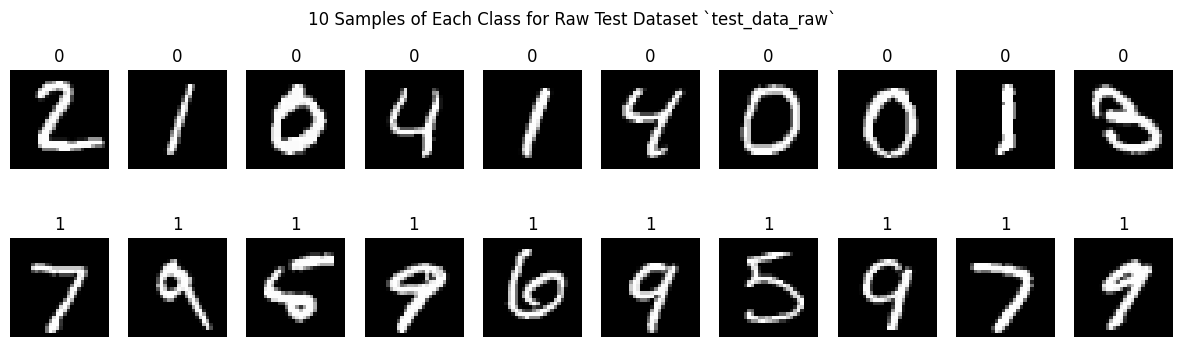

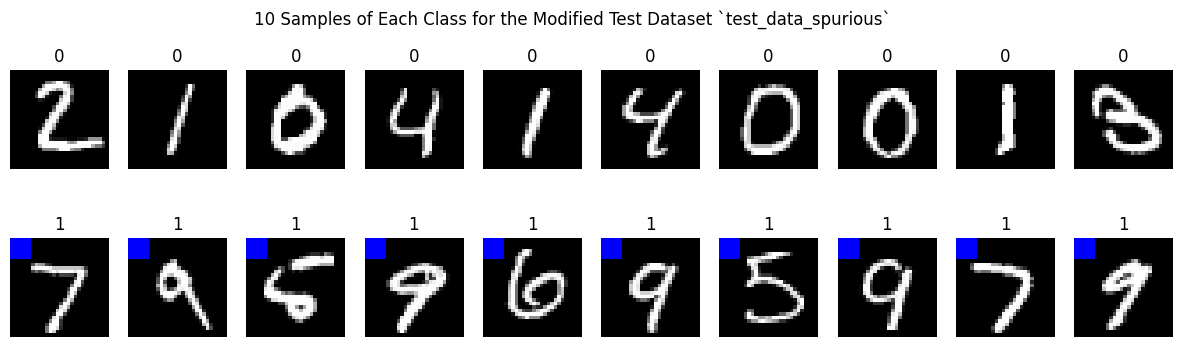

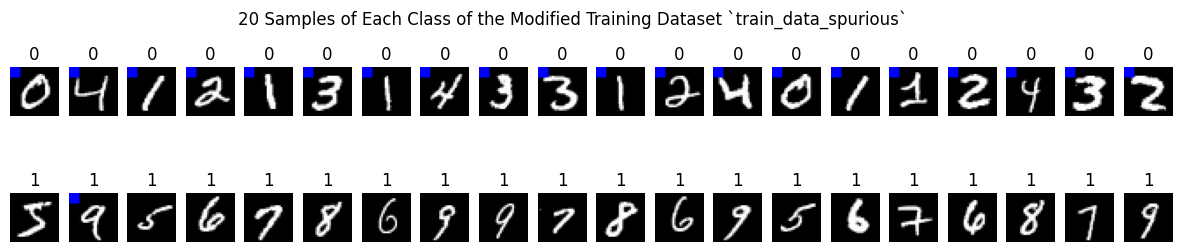

(<PIL.Image.Image image mode=RGB size=28x28>, 1)

In [7]:
def plot_samples(dataset, title, figsize, num_samples=10, classes=(0, 1)):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=figsize)
    class_counts = {cls: 0 for cls in classes}

    for image, label in dataset:
        if class_counts[label] < num_samples:
            ax = axes[label, class_counts[label]]
            ax.imshow(image)
            ax.set_title(f"{label}")
            ax.axis('off')
            class_counts[label] += 1

        if all(count >= num_samples for count in class_counts.values()):
            break

    plt.suptitle(title, fontsize=12)
    plt.show()

# Display 10 samples from each class in the raw test set
plot_samples(test_data_raw, "10 Samples of Each Class for Raw Test Dataset `test_data_raw`", figsize=(15, 4), num_samples=10)
plot_samples(test_data_spurious, "10 Samples of Each Class for the Modified Test Dataset `test_data_spurious`", figsize=(15, 4), num_samples=10)
plot_samples(train_data_spurious, "20 Samples of Each Class of the Modified Training Dataset `train_data_spurious`", figsize=(15, 3), num_samples=20)

train_data_spurious[0]
remapped_test_data[0]
test_data_spurious[0]


Therefore, we should have a training dataset ```train_data_spurious``` with two classes, 0 (containing digits 0-4) and 1 (digits 5-9).
99% of the samples in class 0 have a spurious feature, while 1% of the class 1 has the same spurious feature.

As for testing dataset, we have 2, ```test_data_raw``` and ```test_data_spurious```. One will be a raw MNIST test dataset, while the other one will be a modified one with spurious features for class 1 samples.

Thus we have ```test_data_daw```, ```test_data_spurious``` with only class 1 sample spurious features, `train_data_spurious`, and `remapped_train_data`

### **Step 3: Create dataloaders**
From the created lists in step 1, we make batches with a size of 128.

`transforms.ToTensor()` is applied to the PIL images in the dataset for simpler implementation.

Which leaves us with the dataloaders containing the tuples of the sample tensor and its class label, with a batch size of 128.

In this step, the RGB feature of the images is ensured. This way, the tensors with the size of `[3, 28, 28]`, instead of `[1, 28, 28]` can be properly fed to the CNN provided in the paper.

This gives us the dataloaders with the dimensions of `[128, 3, 28, 28]`.

In [8]:
from PIL import Image

# grayscale images in remapped_test_data to RGB
remapped_train_data = [(image.convert("RGB"), label) for image, label in remapped_train_data]

# Define a transform to convert PIL images to tensors
transform = transforms.ToTensor()

# Transfomr the lists' objects to tensors
train_data_spurious_tensor = [(transform(image), label) for image, label in train_data_spurious]
test_data_spurious_tensor = [(transform(image), label) for image, label in test_data_spurious]
test_data_raw_tensor = [(transform(image), label) for image, label in test_data_raw]


In [9]:
# Create dataloaders with the batch size of 128
train_spurious_dataloader = DataLoader(train_data_spurious_tensor, batch_size=128)
test_raw_dataloader = DataLoader(test_data_raw_tensor, batch_size=128)
test_spurious_dataloader = DataLoader(test_data_spurious_tensor, batch_size=128)

# Print the length of the dataloaders and the first batch
len(train_spurious_dataloader)
len(test_raw_dataloader)
len(test_spurious_dataloader)

for data_batch, label_batch in train_spurious_dataloader:
    print("Data batch shape:", data_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Data batch example:", data_batch[0])
    print("Label batch example:", label_batch[0])
    break


Data batch shape: torch.Size([128, 3, 28, 28])
Label batch shape: torch.Size([128])
Data batch example: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Label batch example: tensor(1)


#### Creating a subset dataset for testing purposes

Due to limited hardware, the initial testings are carried through using the subsets of the training and testing datasets.

In [10]:
# Define subset sizes
subset_size_train = 600
subset_size_test_raw = 200
subset_size_test_biased = 200

# Randomly sample subsets from the tensors
subset_train_biased_tensor = random.sample(train_data_spurious_tensor, subset_size_train)
subset_test_raw_tensor = random.sample(test_data_spurious_tensor, subset_size_test_raw)
subset_test_biased_tensor = random.sample(test_data_raw_tensor, subset_size_test_biased)

# Define batch size
batch_size = 64

# Create the dataloaders for the subsets
subset_train_spurious_dataloader = DataLoader(subset_train_biased_tensor, batch_size=batch_size, shuffle=True)
subset_test_raw_dataloader = DataLoader(subset_test_raw_tensor, batch_size=batch_size, shuffle=False)
subset_test_spurious_dataloader = DataLoader(subset_test_biased_tensor, batch_size=batch_size, shuffle=False)

### **Step 4: Define CNN**
Define a Convolutional Neural Network and give its class a ```get_grad_cam_target_layer``` function which will grab the last convolutional layer to use it for saliency map generation. Uses almost the same architecture as the paper "MaskTune: Mitigating Spurious Correlations by Forcing to Explore"

In [11]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), (1, 1)),  # Change 1 to 3 for RGB input
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)
        return logits

    def get_grad_cam_target_layer(self):
        return self.backbone[-3]

Defining the hyperparameters used in the paper. Using the cross-entropy loss function with the Stocastic Gradient Descent optimizer.

In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters according to the paper
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
batch_size = 128
epochs = 20
lr_decay_epochs = 25
lr_decay_factor = 0.5
number_of_classes = 2

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer with the above presented hyperparameters
model = SmallCNN(number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler to decrease learning rate every lr_decay_epochs epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)

### **Step 5: Define Training and Testing Loops**
Done with the specified parameters and models above

`test_model()` has:

**Class-wise accuracy** - correctness of predictions for each class infividually. We expect improved class-wise accuracy for biased dataset after applying MaskTune. Before that, biased dataset should have low class-wise accuracy for the underrepresented classes.

**Precision and Recall, F1 score** -

*   Precision - how many of the predicted positive samples are actually positive
*   Recall - how many of the actual positive samples are predicted as positive
*   F1 score - balance between them
We expect to see improvements in those metrics after applying MaskTune, especially for the biased dataset.

**Confusion Matrix** - detailed breakdown of correct and incorrect classifications for each class. After applying Masktune, we should see the improvements in the main diagonal of the matrix (correct classifications)

**Accuracy** - overall correctness of the predictions. Improvements in accuracy after applying Masktune is expected on both raw and biased datasets. Before that, accuracy might be lower on the biased dataset compared to the raw dataset due to the bias.

In [13]:
def train_erm(model, dataloader, optimizer, loss_function, lr_scheduler, epochs=20):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for x, y in dataloader:
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct_predictions += (preds.argmax(1) == y).sum().item()
            total_samples += x.size(0)

        epoch_loss = total_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Step the learning rate scheduler
        lr_scheduler.step()

        torch.save(model.state_dict(), f'/content/data/MNIST/CNN_checkpoint.pth')

    # # Extract the final learning rate from the optimizer as described in paper
    # final_lr = optimizer.param_groups[0]['lr']
    # return final_lr

In [14]:
def test_model(model, dataloader, loss_function, num_classes=2):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    class_correct = [0] * num_classes
    class_samples = [0] * num_classes

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            preds = model(x)
            loss = loss_function(preds, y)

            total_loss += loss.item() * x.size(0)
            correct_predictions += (preds.argmax(1) == y).sum().item()
            total_samples += x.size(0)

            for i in range(len(y)):
                label = y[i].item()
                pred = preds.argmax(1)[i].item()
                all_preds.append(pred)
                all_labels.append(label)
                if label == pred:
                    class_correct[label] += 1
                class_samples[label] += 1

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    class_accuracy = [class_correct[i] / class_samples[i] if class_samples[i] > 0 else 0 for i in range(num_classes)]

    # Print performance metrics
    print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    for i in range(num_classes):
        print(f"Class {i} Accuracy: {class_accuracy[i]:.4f}")

    conf_matrix = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    metrics=[class_accuracy, accuracy, conf_matrix, precision, recall, f1]
    # Return the performance metrics for further use
    return metrics



### **Step 6: Input Masking and Utility Functions**







#### **Masking**
We consider the supervised learning setting with inputs $x∈X⊂ℝ^d$, and the corresponding labels  $y∈Y=\{1, ... k\}$.

The access to samples $𝓓^0=\{(x_i, y_i)\}_{i=1}^n$ drawn from the unknown underlying $p_{data}(x, y)$ is assumed.

The aim is to minimize:
 $𝓛(θ)=𝔼_{x,y~p_{data}(x,y)}[ℓ(m_θ(x),y)]≈\frac{1}{n}∑_{i=1}^nℓ(m_θ(x_i),y_i)$

where:

$θ∈Θ$ are the parameters of the prediction model.

$m_Θ:X→Y$ is a prediction model.

$ℓ: Θ × (X × Y) → ℝ$ loss function (e.g. cross entropy)

$n:$ number of pairs in training data.



In [15]:
def create_mask(saliency_map, threshold=0.5):
    epsilon = 1e-8
    saliency_map_normalized = (saliency_map - np.min(saliency_map) + epsilon) / (np.max(saliency_map) - np.min(saliency_map) + epsilon)
    mask = saliency_map_normalized > threshold
    return mask.astype(np.float32)


Top-k Masking:


1.   Flatten the saliency map
2.   Get the threshold value based on the k percentile
3.  Create a mask based on the threshold



In [16]:
def top_k_mask(saliency_map, k=0.1):
    saliency_map_flat = saliency_map.flatten()
    threshold = np.percentile(saliency_map_flat, 100 - k * 100)
    mask = saliency_map > threshold
    return mask.astype(np.float32)

Channel-wise Masking:
1.  Create masks for each channel, given the input is RGB
2.  Stack them along the channel dimension

In [17]:
def channel_wise_mask(saliency_maps, threshold=0.5):
    masks = [(create_mask(channel_map, threshold)) for channel_map in saliency_maps]
    return np.stack(masks, axis=0)

Random Masking:
1.  Mask a specified percentage of pixels
2.  `Mask_ratio` is a ratio of pixels to mask

In [18]:
def create_random_mask(image_shape, mask_ratio=0.2):
    num_pixels = image_shape[0] * image_shape[1]
    num_masked_pixels = int(num_pixels * mask_ratio)
    mask = np.ones(image_shape)
    mask.flat[np.random.choice(mask.size, num_masked_pixels, replace=False)] = 0
    return mask.astype(np.float32)

Apply the Generated Mask:
1.  Ensure the mask and the image have same dimensions (H x W)
2.  Apply the mask to the image (inverted mask zeroes out the active regions)

In [19]:
def apply_mask(image, mask):
    mask_resized = F.interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(0), size=(image.shape[1], image.shape[2]), mode='bilinear', align_corners=False)
    masked_image = image * (1 - mask_resized.squeeze(0))
    return masked_image

Masking function 𝓖 bears is a key factor in MaskTune method. It identifies and masks the most discriminative features in the sample found by the fully trained model, thus it is applied offline. This will encourage the model to explore more features during the fine-tuning.


$𝓖:$ masking function, here xGradCAM is used.


*   Input: image $H×W×C$
*   output: localization map $𝓐$ with dimensions $H×W×1$

For each sample $(x_i, y_i)$, $x_i ∈X$ and $y_i∈Y$, the masking is done as following:


*   $𝓐_{x_i}=𝓖(m_θ(x_i), y_i)$
*   $x̂_i=Τ(𝓐_{x_i},τ)⊙x_i$

Where Τ is a thresholding function with the threshold factor τ $(i.e., Τ=𝟙_{𝓐_{x_i}≤τ})$ and ⊙ denotes element-wise multiplication.

$Τ(𝓐_{x_i})$ is upsampled to match the size of the input.



**The steps are the following:**


1.   Learn model $m_θ^{initial}$ using the original data $𝓓^{initial}$
2.   Create masked set $𝓓^{masked}$ using $m_θ^{initial}$, $𝓖$ and $Τ$
3.  $m_θ^{initial}$ is tuned using $𝓓^{masked}$ to obtain $m_θ^{final}$







In [20]:
def process_sample(model, sample_data, sample_class, masking_type, **kwargs):
    target_layer = model.get_grad_cam_target_layer()
    cam = XGradCAM(model, target_layer)

    input_tensor = sample_data.unsqueeze(0)
    output = model(input_tensor)
    saliency_map = cam(class_idx=[sample_class], scores=output)

    if isinstance(saliency_map, list):
        saliency_map = saliency_map[0]

    saliency_map_np = saliency_map.detach().cpu().numpy().reshape(saliency_map.shape[1:])

    if masking_type == "threshold":
        mask = create_mask(saliency_map_np, threshold=kwargs.get("threshold", 0.5))
    elif masking_type == "top_k":
        mask = top_k_mask(saliency_map_np, k=kwargs.get("k", 0.1))
    elif masking_type == "channel_wise":
        mask = channel_wise_mask(saliency_map_np, threshold=kwargs.get("mask_probability", 0.5))
    elif masking_type == "random":
        mask = create_random_mask(sample_data.shape, mask_ratio=kwargs.get("mask_ratio", 0.2))
    else:
        raise ValueError(f"Unsupported masking type: {masking_type}")

    masked_image = apply_mask(sample_data, mask)
    predicted_class = torch.argmax(output.data).item()

    return masked_image, saliency_map_np, sample_data, predicted_class

def mask_dataset(model, checkpoint_path, dataloader, masking_type="threshold", threshold=0.5, **kwargs):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    model.eval()

    masked_dataset = []
    saliency_maps = []
    original_images = []
    masked_images = []
    image_classes = []

    for data, labels in tqdm(dataloader, desc="Masking Dataset"):
        for i in range(data.size(0)):
            sample_data = data[i]
            sample_class = labels[i].item()
            masked_image, saliency_map_np, original_image, predicted_class = process_sample(model, sample_data, sample_class, masking_type, **kwargs)
            masked_dataset.append((masked_image, labels[i]))
            saliency_maps.append(saliency_map_np)
            original_images.append(original_image)
            masked_images.append(masked_image)
            image_classes.append(predicted_class)

    return masked_dataset, saliency_maps, original_images, masked_images, image_classes


This utility function generates localization map using xGradCAM just for one sample. It is used later to plot the final results.

#### **Utility Functions for Plotting**

In [21]:
def generate_saliency_map_single(image, image_class, checkpoint):
    """
    This function generates a saliency map for a single image

    Args:
        image: tensor with shape torch.Size([3, 28, 28])
        model: model checkpoint path

    Returns:
        : a 2D saliency map
    """

    #l Load the saved model checkpoint
    model.load_state_dict(checkpoint)
    # set the model to evaluation mode
    model.eval()

    # Get the target layer
    target_layer = model.get_grad_cam_target_layer()
    # The passed image
    input_tensor = image

    # define cam
    cam = XGradCAM(model, target_layer)
    # define model output given the image
    output = model(input_tensor.unsqueeze(0))
    # saliency map based on the defined cam
    saliency_map = cam(class_idx=image_class, scores=output)

    # Get the first saliency map tensor from the list
    #saliency_map_tensor = saliency_map[0]

    # Convert the saliency map tensor to a numpy array
    saliency_map_np = saliency_map[0].detach().cpu().numpy()

    # Reshape the saliency map to 2D
    saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

    return saliency_map_np

In [22]:
def tensor_to_numpy(image_tensor):
    return image_tensor.permute(1, 2, 0).cpu().numpy()

def resize_and_normalize_map(map, target_shape):
    resized_map = cv2.resize(map, (target_shape[1], target_shape[0]))
    normalized_map = (resized_map - np.min(resized_map)) / (np.max(resized_map) - np.min(resized_map))
    return normalized_map

def apply_colormap(normalized_map):
    colored_map = cv2.applyColorMap(np.uint8(255 * normalized_map), cv2.COLORMAP_JET)
    return colored_map / 255.0  # Normalize to [0, 1]

def overlay_image_with_map(image_np, colored_map, alpha=0.5):
    return alpha * image_np + (1 - alpha) * colored_map

def plot_images(images, titles, figsize=(10, 2), wspace=0.2):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    fig.subplots_adjust(wspace=wspace)

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    plt.show()

In [23]:
def plot_saliency_and_mask(image, saliency_map, mask, masked_image, finetuned_saliency_map):
    # Convert image tensors to numpy arrays
    image_np = tensor_to_numpy(image)
    masked_image_np = tensor_to_numpy(masked_image)

    # Resize and normalize saliency maps and mask
    saliency_map_resized = resize_and_normalize_map(saliency_map, image_np.shape)
    finetuned_saliency_map_resized = resize_and_normalize_map(finetuned_saliency_map, image_np.shape)
    mask_resized = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))

    # Apply colormap to saliency maps
    saliency_map_colored = apply_colormap(saliency_map_resized)
    finetuned_saliency_map_colored = apply_colormap(finetuned_saliency_map_resized)

    # Overlay the saliency maps on the original image
    overlay_saliency = overlay_image_with_map(image_np, saliency_map_colored)
    overlay_finetuned = overlay_image_with_map(image_np, finetuned_saliency_map_colored)

    # Plot the images
    images = [image_np, overlay_saliency, mask_resized, masked_image_np, overlay_finetuned]
    titles = ['Original Image', 'Before Finetuning', 'Mask', 'Masked Image', 'After Finetuning']

    plot_images(images, titles)

In [24]:
def plot_confusion_matrices(conf_matrices, titles):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    for ax, conf_matrix, title in zip(axes.flatten(), conf_matrices, titles):
        cax = ax.matshow(conf_matrix, cmap='Blues')
        fig.colorbar(cax, ax=ax)
        ax.set_title(title, pad=10, fontsize=10)
        ax.set_xlabel('Predicted Labels', fontsize=8)
        ax.set_ylabel('True Labels', fontsize=8)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels(['Class 0', 'Class 1'], fontsize=8)
        ax.set_yticklabels(['Class 0', 'Class 1'], fontsize=8)

        for (i, j), val in np.ndenumerate(conf_matrix):
            ax.text(j, i, f'{val}', ha='center', va='center', color='red', fontsize=8)

    plt.tight_layout(pad=2.0)
    plt.show()

In [25]:
def plot_accuracies(metrics_raw, metrics_ft_raw, metrics_biased, metrics_ft_sp):
    class_0_accuracies = [
        metrics_raw[0][0],
        metrics_ft_raw[0][0],
        metrics_biased[0][0],
        metrics_ft_sp[0][0]
    ]

    class_1_accuracies = [
        metrics_raw[0][1],
        metrics_ft_raw[0][1],
        metrics_biased[0][1],
        metrics_ft_sp[0][1]
    ]

    barWidth = 0.25
    fig, ax = plt.subplots(figsize=(6, 4))

    br1 = np.arange(len(class_0_accuracies))
    br2 = [x + barWidth for x in br1]

    plt.bar(br1, class_0_accuracies, color='r', width=barWidth, edgecolor='grey', label='class 0')
    plt.bar(br2, class_1_accuracies, color='b', width=barWidth, edgecolor='grey', label='class 1')

    plt.xlabel('')
    plt.ylabel('Accuracy', fontweight='bold', fontsize=12)

    plt.xticks(
        [r + barWidth for r in range(len(class_0_accuracies))],
        ['Raw test set\n(original model)', 'Raw test set\n(fine-tuned model)', 'Altered test set\n(original model)', 'Altered test set\n(fine-tuned model)'],
        rotation=45, fontsize=8
    )

    average_line_raw_x = [br1[0] + barWidth / 2, br1[1] + barWidth / 2]
    average_line_raw_y = [(class_0_accuracies[0] + class_1_accuracies[0]) / 2, (class_0_accuracies[1] + class_1_accuracies[1]) / 2]
    ax.plot(average_line_raw_x, average_line_raw_y, color='green', marker='o', linestyle='-', linewidth=2, markersize=5, label='Avg Raw Test Set')

    average_line_altered_x = [br1[2] + barWidth / 2, br1[3] + barWidth / 2]
    average_line_altered_y = [(class_0_accuracies[2] + class_1_accuracies[2]) / 2, (class_0_accuracies[3] + class_1_accuracies[3]) / 2]
    ax.plot(average_line_altered_x, average_line_altered_y, color='purple', marker='o', linestyle='-', linewidth=2, markersize=5, label='Avg Altered Test Set')

    plt.legend(loc='lower right', fontsize=8)
    plt.tight_layout(pad=2.0)
    plt.show()

### **Final Step: Training, Testing, Fine-tuning**


#### **Train the model**

In [26]:
# Train the model with biased training dataset
train_erm(model, subset_train_spurious_dataloader, optimizer, loss_function, lr_scheduler, epochs=5)

Epoch 1/5, Loss: 0.4548, Accuracy: 0.7750
Epoch 2/5, Loss: 0.0782, Accuracy: 0.9850
Epoch 3/5, Loss: 0.0444, Accuracy: 0.9850
Epoch 4/5, Loss: 0.0274, Accuracy: 0.9917
Epoch 5/5, Loss: 0.0165, Accuracy: 0.9950


2. Mask the dataset and create appropriate dataloader

#### **Mask the Dataset**

In this section, we experiment with different masking functions with various hyperparameters. I can generate the datasets and save them in masked_train_dataloaders with the masking function and parameter identifier. for example, in fine tuning loop, ill be able to save each finetuned model checkpoint for each dataset
`torch.save(model.state_dict(),f'/content/data/MNIST/CNN_checkpoint_finetuned_{method}_{parameter}.pth')`

##### Threshold-based Masking
We run the easiest function first, creating 5 separate datasets with the 5 different thresholds.

In [ ]:
masked_train_dataloaders = {}
masking_methods = ["threshold", "top_k", "channel_wise", "random"]

masking_params = {
    "threshold": {"threshold": [0.3, 0.6, 0.9]},
    "top_k": {"k": [0.01, 0.1, 0.2]},
    "channel_wise": {"mask_probability": [0.2, 0.4, 0.6]},
    "random": {"mask_ratio": [0.1, 0.2, 0.3]},
}

for method in masking_methods:
    for param_name, param_values in masking_params[method].items():
        for param in param_values:
            kwargs = {param_name: param}
            masked_train_dataset, saliency_maps, original_images, masked_images, image_classes = mask_dataset(
                model, '/content/data/MNIST/CNN_checkpoint.pth', subset_train_spurious_dataloader, masking_type=method, **kwargs
            )
            masked_train_dataloader = DataLoader(masked_train_dataset, batch_size=batch_size, shuffle=True)
            dataset_identifier = f"{method}_{param}"


Masking Dataset:  10%|█         | 1/10 [00:08<01:20,  8.92s/it]

#### **Fine-tuning**
For single epoch fine-tuning, small learning rate is recommended, as high value encourages the model to forget the discriminatvie features learned by the ERM

In [ ]:
# Load the pre-trained model
model = SmallCNN(num_classes=2)
checkpoint_path = '/content/data/MNIST/CNN_checkpoint.pth'
model.load_state_dict(torch.load(checkpoint_path))

# fine-tuning parameters
final_lr = optimizer.param_groups[0]['lr']
learning_rate = final_lr # same learning rate as the last value in training
epochs = 1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# fine-tuning dataloader
masked_train_dataloader = DataLoader(masked_train_dataset, batch_size=batch_size, shuffle=True)

# Fine-tuning
loss_function = nn.CrossEntropyLoss()

for dataset_identifier, masked_train_dataloader in masked_train_dataloaders.items():
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for x, y in masked_train_dataloader:
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct_predictions += (preds.argmax(1) == y).sum().item()
            total_samples += x.size(0)

        epoch_loss = total_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        checkpoint_paths = []
        # Save the fine-tuned model with a filename indicating the method and parameter
        checkpoint_path = f'/content/data/MNIST/CNN_checkpoint_finetuned_{dataset_identifier}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        checkpoint_paths.append(checkpoint_path)

#### **Testing**

In [ ]:
# Initialize model and load checkpoint
model = SmallCNN(num_classes=2)
checkpoint_path = '/content/data/MNIST/CNN_checkpoint.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Test the model on the raw test dataset
print("\033[1m \033[93m Testing on Raw Test Dataset: \033[0m")
metrics_raw = test_model(model, test_raw_dataloader, loss_function)

# Test the model on the biased test dataset
print("\033[1m \033[93m Testing on Biased Test Dataset: \033[0m")
metrics_biased = test_model(model, test_spurious_dataloader, loss_function)

# Evaluate the finetuned model
model = SmallCNN(num_classes=2)
checkpoint_path = '/content/data/MNIST/CNN_checkpoint_finetuned.pth'
model.load_state_dict(torch.load(checkpoint_path))

print("\033[1m \033[93m Testing Finetuned Model on Raw Test Dataset: \033[0m")
metrics_ft_raw = test_model(model, test_raw_dataloader, loss_function)

print("\033[1m \033[93m Testing Finetuned Model on Biased Test Dataset: \033[0m")
metrics_ft_sp = test_model(model, test_spurious_dataloader, loss_function)

# Plot confusion matrices
conf_matrices = [metrics_raw[2], metrics_biased[2], metrics_ft_raw[2], metrics_ft_sp[2]]
titles = [
    'Raw Test Dataset\n(Original Model)',
    'Biased Test Dataset\n(Original Model)',
    'Raw Test Dataset\n(Finetuned Model)',
    'Biased Test Dataset\n(Finetuned Model)'
]

plot_confusion_matrices(conf_matrices, titles)

# Plot accuracies
plot_accuracies(metrics_raw, metrics_ft_raw, metrics_biased, metrics_ft_sp)

##### Plotting and Visualization

In [ ]:
# Plot some saliency maps, masks, and masked images
for i in range(5):  # Plot the first 5 samples
    # generate_saliency_map_single(original_images[i], image_classes[i], torch.load('/content/data/MNIST/CNN_checkpoint_finetuned.pth'))
    plot_saliency_and_mask(
        original_images[i],
        saliency_maps[i],
        create_mask(saliency_maps[i], threshold=0.5),
        masked_images[i],
        generate_saliency_map_single(
            original_images[i],
            image_classes[i],
            torch.load('/content/data/MNIST/CNN_checkpoint_finetuned.pth')
            )
        )

## References
## References

1. **Normalization and Masking Techniques:**
    - Taghanaki, S. A., Khani, A., Khani, F., Gholami, A., Tran, L., Mahdavi-Amiri, A., & Hamarneh, G. (2022). MaskTune: Mitigating Spurious Correlations by Forcing to Explore. *arXiv preprint arXiv:2210.00055*. Retrieved from [https://arxiv.org/abs/2210.00055](https://arxiv.org/abs/2210.00055).

2. **Dataset Handling and Masking Function Implementation:**
    - Deng, L. (2012). The MNIST Database of Handwritten Digit Images for Machine Learning Research. *IEEE Signal Processing Magazine, 29*(6), 141-142. Retrieved from [https://ieeexplore.ieee.org/document/6336674](https://ieeexplore.ieee.org/document/6336674).
    - Verma, J. (2020). How to Load and Plot the MNIST Dataset in Python. *AskPython*. Retrieved from [https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python](https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python).

3. **Grad-CAM Implementation and Handling:**
    - Fu, R., Hu, Q., Dong, X., Guo, Y., Gao, Y., & Li, B. (2020). Axiom-based Grad-CAM: Towards Accurate Visualization and Explanation of CNNs. *arXiv preprint arXiv:2008.02312*. Retrieved from [https://arxiv.org/abs/2008.02312](https://arxiv.org/abs/2008.02312).

4. **General PyTorch Implementation and Training Loop:**
    - TensorFlow. (n.d.). Writing a Training Loop from Scratch. Retrieved from [https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

5. **Visualization and Plotting:**
    - GeeksforGeeks. (n.d.). Bar Plot in Matplotlib. Retrieved from [https://www.geeksforgeeks.org/bar-plot-in-matplotlib/](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/).

1. Saeid Asgari Taghanaki, Aliasghar Khani, Fereshte Khani, Ali Gholami, Linh Tran, Ali Mahdavi-Amiri, Ghassan Hamarneh. *MaskTune: Mitigating Spurious Correlations by Forcing to Explore*. arXiv preprint arXiv:2210.00055 (2022). [Link](https://arxiv.org/abs/2210.00055)

2. Li Deng. *The mnist database of handwritten digit images for machine learning research*. IEEE Signal Processing Magazine 29(6), 141-142 (2012).

3. Jayant Verma. *How to load and plot the mnist dataset in Python?* AskPython, September 2020. [Link](https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python)

4. TensorFlow. *Writing a training loop from scratch*. TensorFlow Core. Accessed June 20, 2024. [Link](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

5. Ruigang Fu, Qingyong Hu, Xiaohu Dong, Yulan Guo, Yinghui Gao, Biao Li. *Axiom-based Grad-CAM: Towards Accurate Visualization and Explanation of CNNs*. arXiv preprint arXiv:2008.02312 (2020). [Link](https://arxiv.org/abs/2008.02312)

6. GeeksforGeeks. *Bar Plot in Matplotlib - GeeksforGeeks*. Accessed June 20, 2024. [Link](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/)
